In [7]:
import torch
import torch.autograd as autograd  # computation graph
from torch import Tensor  # tensor node in the computation graph
import torch.nn as nn  # neural networks
import torch.optim as optim  # optimizers e.g. gradient descent, ADAM, etc.

import numpy as np
from timeit import default_timer as timer
from pyDOE import lhs  # Latin Hypercube Sampling
import scipy.io
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import math
import scipy.special
import itertools
from itertools import product

#PyTorch random number generator
torch.manual_seed(1234)

# Random number generators in other libraries
np.random.seed(1234)

In [8]:
def training_data_lhb(lb, ub, N_inner):
    '''Boundary Conditions'''


    '''Collocation Points'''

    # latin_hypercube
    x_train = lb + (ub - lb) * lhs(2, int(N_inner))

    return x_train

In [9]:
class Sequentialmodel(nn.Module):

    def __init__(self, layers, device):
        super().__init__()  # call __init__ from parent class
        self.layers = layers
        self.device = device
        self.activation = nn.Tanh()
        self.loss_function = nn.MSELoss(reduction='mean')
        self.linears = nn.ModuleList([nn.Linear(layers[i], layers[i + 1]) for i in range(len(layers) - 1)])
        self.iter = 0
        self.C1 = 0.2
        self.C2 = 0.2
        self.G1 = 2
        self.M1 = 2
        self.G2 = 2
        self.M2 = 2
        self.r = 0.1
        self.N = 11 # Legendre基底个数
        self.N_G = 11 # Gauss-Legendre求积公式节点数
        self.alpha1 = 1.5
        self.alpha2 = 1.5
        self.s = 2  # alpha1的向上取整
        
        self.d1 = self.C1 * math.gamma(-self.alpha1)
        self.d2 = self.C2 * math.gamma(-self.alpha1)
        
        self.nu1 = self.d1*(pow(self.G1+1,self.alpha1)-pow(self.G1,self.alpha1)+pow(self.M1-1,self.alpha1)-pow(self.M1,self.alpha1))
        self.nu2 = self.d2*(pow(self.G2+1,self.alpha2)-pow(self.G2,self.alpha2)+pow(self.M2-1,self.alpha2)-pow(self.M2,self.alpha2))
        #print("self.nu1",self.nu1)
        #print("self.nu2",self.nu2)
        self.b1 =  self.r -  self.nu1
        self.b2 =  self.r -  self.nu2
        
        # 计算1/4*(2i+1)*(2j+1) Create Di and Dj ( 2i+1的列向量[N+1,1] 和 2j+1的行向量 [1 , N+1]）
        self.Di = 2 * torch.arange(self.N + 1)[:, None] + 1
        self.Dj = 2 * torch.arange(self.N + 1) + 1
        #print("Di", Di.shape)

        # x_k 和 w_k是Gauss-Legendre求积公式的节点和权重(行向量)
        self.x_k, self.w_k = scipy.special.roots_legendre(self.N_G + 1)
        self.x_k, self.w_k= torch.from_numpy(self.x_k).float(), torch.from_numpy(self.w_k).float()
        
        # a = b = 0时是勒让德多项式 :[[L0(x0),L0(x1),...,L0(N_G)],\\...,[LN(x0),LN(x1),...,LN(N_G)]] 维度(N+1,N_G+1)
        #self.L = torch.reshape(self.jacobi_polynomial(0, 0, self.x_k, self.N ), [-1, self.N])
        self.L = self.jacobi_polynomial(0, 0, self.x_k, self.N)
        
        #[[w0w0,w0w1,...w0wN_G],\\...,[wN_Gw0,wN_Gw1,...wN_GwN_G]] 维度:(N_G+1，N_G+1)
        self.W = torch.outer(self.w_k, self.w_k)
        
         # Compute outer product of Lagrange basis functions
        self.Li = self.L
        self.Lj = self.L.T
        
        
        ## 计算导数部分中 gamma(k+2)/gamma(k-alpha+2)
        coe1 = []
        for j in range(self.N):
            temp = torch.tensor(math.gamma(j + 2) / math.gamma(j - self.alpha1 + 2))
            coe1.append(temp)
        self.coe1 = torch.vstack(coe1)
        #print("coe1:",self.coe1)
        
        ## 计算导数部分中 L0分数阶导数系数
        self.coe2 = (1 / math.gamma(self.s - self.alpha1) * (self.s - self.alpha1 - 1))


        'Xavier Normal Initialization'
        for i in range(len(layers) - 1):
            nn.init.xavier_normal_(self.linears[i].weight.data, gain=1.0)
            nn.init.zeros_(self.linears[i].bias.data)

    'foward pass'

    def forward(self, x_t):
        if torch.is_tensor(x_t) != True:
            x_t = torch.from_numpy(x_t).float().to(self.device)

        for i in range(len(self.layers) - 2):
            z = self.linears[i](x_t)
            # print("z:",z)
            x_t = self.activation(z)

        output = self.linears[-1](x_t)
        # print("output:",output)
        return output


    def jacobi_polynomial(self, a, b, x, N):
        jacobi = [torch.ones(x.shape)]
        p0 = 1
        p1 = 1 / 2 * (a + b + 2) * x + 1 / 2 * (a - b)
        jacobi.append(p1)
        for i in range(1, N):
            A = (2 * i + a + b + 1) * (2 * i + a + b + 2) / (2 * (i + 1) * (i + a + b + 1))
            B = (b ** 2 - a ** 2) * (2 * i + a + b + 1) / (2 * (i + 1) * (i + a + b + 1) * (2 * i + a + b))
            C = (i + a) * (i + b) * (2 * i + a + b + 2) / ((i + 1) * (i + a + b + 1) * (2 * i + a + b))
            p = (A * x - B) * p1 - C * p0
            p0 = p1
            p1 = p
            jacobi.append(p1)
            # print("jacobi",jacobi)
        jacobi = torch.vstack(jacobi)
        return jacobi

    def fra_term(self, input):
        # Dl_n_result = [[-1D(LN-1(x0）+LN(x0),-1D(LN-1(x1）+LN(x1),...],\\...
        #                [-1D(L0(x0）+L1(x0),-1D(L0(x1）+L1(x1),...] 维度(N,x.shape(0))
        fra_jacobi_l = torch.reshape(self.jacobi_polynomial(self.alpha1, 1 - self.alpha1, input, self.N - 1 ), [self.N , -1])
        Dl_n_result = self.coe1 * fra_jacobi_l @ torch.diag(torch.pow(1 + input, 1 - self.alpha1).squeeze(1))
        #print("Dl_n_result",Dl_n_result)
        Dl_n_result = torch.flip(Dl_n_result, dims=[0])
        #print("Dl_n_result",Dl_n_result)
        # Dl_L0 = [-1D(L0(x0)),-1D(L0(x1),...]
        Dl_L0 = torch.reshape(self.coe2 * torch.pow(1 + input, self.s - self.alpha1 - 2), (1, input.shape[0]))
        #print("Dl_L0",Dl_L0)

        # Dl = [[-1D(LN-1(x0）+LN(x0),-1D(LN-1(x1）+LN(x1),...],\\...
        #       [-1D(L0(x0）+L1(x0),-1D(L0(x1）+L1(x1),...],\\
        #       [-1D(L0(x0)),-1D(L0(x1),...]].T 维度(x.shape[0],N + 1)
        Dl = torch.cat((Dl_n_result, Dl_L0), dim = 0).T
        #升维 生成三维矩阵，每个矩阵是一个x0 维度(x.shape[0], N + 1, 1)
        Dl = Dl.unsqueeze(2)
        #print("Dl", Dl)

        # Dr_n_result = [[1D(LN-1(x0）-LN(x0),1D(LN-1(x1）-LN(x1),...],\\...
        #                [1D(L0(x0）-L1(x0), 1D(L0(x1）-L1(x1),...] 维度(N, x.shape(0))
        fra_jacobi_r = torch.reshape(self.jacobi_polynomial(1 - self.alpha1, self.alpha1, input, self.N - 1 ), [self.N , -1])
        Dr_n_result = self.coe1 * fra_jacobi_r @ torch.diag(torch.pow(1 - input, 1 - self.alpha1).squeeze(1))
        #print("Dr_n_result",Dr_n_result)
        Dr_n_result = torch.flip(Dr_n_result, dims=[0])
        #print("Dr_n_result",Dr_n_result)
        # Dl_L0 = [-1D(L0(x0)),-1D(L0(x1),...]
        Dr_L0 = torch.reshape(self.coe2 * torch.pow(1 - input, self.s - self.alpha1 - 2), (1, input.shape[0]))
        Dr = torch.cat((Dr_n_result, Dr_L0), dim = 0).T
        Dr = Dr.unsqueeze(2)

        return Dl, Dr

    def compute_matrix_A(self, t):
        
        #t从列向量变为行向量
        t = t.squeeze(1)
        
        #三维笛卡尔积 t * x_k * x_k
        t_xk_yk = torch.cartesian_prod(t , self.x_k, self.x_k )
        # 调整笛卡尔积结果为： [[x0,x0,t0],\\[x0,x1,t0],\\...[x0,xN_G,t0],\\[x1,x0,t0],\\...[xN_G,xN_G,tN_t]] 
        # 维度（(N_G+1)*(N_G+1)*(N_t+1),1）
        adjusted_tensor = t_xk_yk[:, 1:].clone()  # 复制除第一列外的所有列
        xk_yk_t = torch.cat((adjusted_tensor, t_xk_yk[:, 0:1]), dim=1)
        #print("xk_xk_t ",xk_xk_t)

        # 上述数据的网络值
        V = self.forward(xk_yk_t)
        #V = (torch.exp(-xk_yk_t[:,0]) * torch.exp(-xk_yk_t[:,1]) * torch.cos(xk_yk_t[:,-1]))[:,None]
        #print("V",V)
        #print(t.shape[0])
        
        # 改成三维矩阵，每一块是一个时间的矩阵(N_t为时间的个数)维度：(N_t + 1,N_G + 1,N_G + 1)
        #   [[[V(x0,x0,t0),V(x0,x1,t0),...V(x0,xN_G,t0)],\\
        #   [V(x1,x0,t0),V(x1,x1,t0),...V(x1,xN_G,t0)],\\...
        #   [V(xN_G,x0,t0),V(xN_G,x1,t0),...V(xN_G,xN_G,t0)]],\\\\...
        #   [[V(x0,x0,tN_t),V(x0,x1,tN),...V(x0,xN_G,tN_t)],\\
        #   [V(x1,x0, tN_t),V(x1,x1,tN_t),...V(x1,xN_G,tN_t)],\\...
        #   [V(xN_G,x0,tN_t),V(xN_G,x1,tN_t),...V(xN_G,xN_G,tN_t)]]]
        V = torch.reshape(V, [t.shape[0], self.N_G + 1, self.N_G + 1 ] )
        #print("V",V)
        
        # [[exp(Gx0)],\\...,[exp(GxN_G)]]
        EG = torch.exp(self.G1 * self.x_k)[:,None]
        
        
        #print("E",E)
        

        # Compute outer product of weights (N_t + 1, N_G + 1, N_G + 1)
        #   [[[e^Gx0*V(x0,x0,t0),e^Gx0*V(x0,x1,t0),...e^Gx0*V(x0,xN_G,t0)],\\
        #   [e^Gx1*V(x1,x0,t0),e^Gx1*V(x1,x1,t0),...e^Gx1*V(x1,xN_G,t0)],\\...
        #   [e^GxN_G*V(xN_G,x0,t0),e^GxN_G*V(xN_G,x1,t0),...e^GxN_G*V(xN_G,xN_G,t0)]],\\\\...
        #   [[e^Gx0*V(x0,x0,tN_t),e^Gx0*V(x0,x1,tN_t),...e^Gx0*V(x0,xN_G,tN_t)],\\
        #   [e^Gx1*V(x1,x0, tN_t),e^Gx1*V(x1,x1,tN_t),...e^Gx1*V(x1,xN_G,tN_t)],\\...
        #   [e^GxN_G*V(xN_G,x0,tN_t),e^GxN_G*V(xN_G,x1,tN_t),...e^GxN_G*V(xN_G,xN_G,tN_t)]]]
        EGV = EG * V  
        WEGV =  self.W * EGV
        # Compute matrix a_l(t) = aij(t)
        a_l = 0.25 * self.Di * self.Li @ WEGV @ self.Lj * self.Dj
        #print("a_l", a_l)
        
        EM = torch.exp(-self.M1 * self.x_k)[:,None]
        EMV = EM * V
        WEMV =  self.W * EMV
        a_r = 0.25 * self.Di * self.Li @ WEMV @ self.Lj * self.Dj
        
        #print("a_r",a_r)

        ##计算A矩阵

        Ax_l =   a_l[:, self.N ,:].unsqueeze(1)
        Ax_r = - a_r[:, self.N, :].unsqueeze(1)
        #print("Ax_r", Ax_r)
        
        for i in range(self.N):
            temp_l =   a_l[:, self.N - 1 - i,:].unsqueeze(1) - Ax_l[:,i,:].unsqueeze(1)
            temp_r = - a_r[:, self.N - 1 - i,:].unsqueeze(1) + Ax_r[:,i,:].unsqueeze(1)
            Ax_l = torch.cat((Ax_l, temp_l), dim=1)
            Ax_r = torch.cat((Ax_r, temp_r), dim=1)
        #print("Ax_r", Ax_r)
        #Ax_r的最后一行乘-1
        I = torch.Tensor([1]*self.N + [-1])[:,None]
        Ax_r = I * Ax_r
        #print("Ax_r", Ax_r)

        return  Ax_l, Ax_r



    def compute(self, x_t):
        x , y, t = x_t[:, 0][:, None], x_t[:, 1][:, None], x_t[:, -1][:, None]

        #Ax_l = self.compute_matrix_A(t)
        Ax_l, Ax_r = self.compute_matrix_A(t)
        Dx_l, Dx_r = self.fra_term(x)
        Dy_l, Dy_r = self.fra_term(y)
        #Dy_l = self.fra_term(y)
        #print("Dx_l",Dx_l)
        #print("Dx_r",Dx_r)
        
        ## Lj_y = [[[L0(y0),L1(y0),...,LN(y0)]],\\...,
        #          [LN(yN_t),LN(yN_t),...,LN(yN_t)]]] 维度(N_t+1, N+1, N+1)
        Lj_y = torch.reshape(self.jacobi_polynomial(0, 0, y, self.N), [self.N + 1, -1]).T.unsqueeze(1)
        
        Lj_x = torch.reshape(self.jacobi_polynomial(0, 0, x, self.N), [self.N + 1, -1]).T.unsqueeze(1)
        
        #print("Lj_y",Lj_y)
        #print("Bl",B_l)
        #print("Br",Br)
        #print("Ax_r * Dx_r",Ax_r * Dx_r)
        test_x_l = Lj_y * Ax_l * Dx_l
        test_x_r = Lj_y * Ax_r * Dx_r
        
        test_y_l = Lj_x * Ax_l * Dy_l
        test_y_r = Lj_x * Ax_r * Dy_r
        #print("test",test)
        
        result_x_l = torch.exp(-self.G1 * x) * torch.sum(torch.sum(test_x_l,1),1)[:,None]
        result_x_r = torch.exp( self.M1 * x) * torch.sum(torch.sum(test_x_r,1),1)[:,None]
        
        result_y_l = torch.exp(-self.G1 * y) * torch.sum(torch.sum(test_y_l,1),1)[:,None]
        result_y_r = torch.exp( self.M1 * y) * torch.sum(torch.sum(test_y_r,1),1)[:,None]
        #print("result", result)
        return result_x_l, result_x_r,result_y_l, result_y_r
        #return result_y_l
    
    'non-homogeneous term for Loss'
    def fun_fx(self, x_t):
        # print("x:",x)
        x , y, t = x_t[:, 0][:, None], x_t[:, 1][:, None], x_t[:, -1][:, None]
        a_l = self.G1 - 1
        a_r = self.M1 + 1
        k = self.alpha1 - self.s + 1

        m = 1 - k
        n_l = torch.mul(a_l, 1 + x)
        n_r = torch.mul(a_r, 1 - x)

        max_iter = 20  # 最大迭代次数
        result_l, result_r = 0.0, 0.0  # 结果初始化
        mul = 1
        for _ in range(max_iter):
            mul *= m + _
            # print("mul:",mul)
            term_l = torch.pow(n_l, _) / mul
            term_r = torch.pow(n_r, _) / mul
            result_l += term_l
            result_r += term_r
        result1 = math.gamma(m) - torch.pow(n_l, m) * torch.exp(-n_l) * result_l
        result2 = math.gamma(m) - torch.pow(n_r, m) * torch.exp(-n_r) * result_r

        # result1 = result1 * math.gamma(s - self.alpha1)
        # x = torch.from_numpy(x).float().to(self.device)
        temp_l = a_l ** self.alpha1 * torch.exp(-x) * result1 - \
                 a_l * torch.exp(-self.G1 * x - self.G1 + 1) * torch.pow(1 + x, (-self.alpha1 + 1)) + \
                 (self.alpha1 - 1) * torch.exp(-self.G1 * x - self.G1 + 1) * torch.pow(1 + x, -self.alpha1)
        left = a_l ** self.alpha1 * torch.exp(-x) - 1 / math.gamma(self.s - self.alpha1) * temp_l

        
        temp_r = a_r ** self.alpha1 * torch.exp(-x) * result2 - \
                 a_r * torch.exp(self.M1 * x - self.M1 - 1) * torch.pow(1 - x, (-self.alpha1 + 1)) + \
                 (self.alpha1 - 1) * torch.exp(self.M1 * x - self.M1 - 1) * torch.pow(1 - x, -self.alpha1)
        right = a_r ** self.alpha1 * torch.exp(-x) - 1 / math.gamma(self.s - self.alpha1) * temp_r
        

        
        fx = (left + right)  * torch.exp(-y) * torch.cos(t) #- \
             #(pow(self.G1, self.alpha1)+ pow(self.M1, self.alpha1))* torch.exp(-x) * torch.exp(-y) * torch.cos(t) 
        #fx = (left + right) * torch.exp(-y) * torch.cos(t) - (pow(self.G1, self.alpha1)+ pow(self.M1, self.alpha1)) * torch.exp(-x) * torch.exp(-y) * torch.cos(t)
        #f = -torch.exp(-x)*torch.sin(t) -(left +right- pow(self.G, self.alpha1) * torch.exp(-x)- \
        #                                  pow(self.M1, self.alpha1) * torch.exp(-x))*torch.cos(t)
        #f = (right-pow(self.M1, self.alpha1) * torch.exp(-x))*torch.cos(t)
        # print("f:",f)
        #fx = self.d1 * fx 
        return fx
    
    def fun_fy(self, x_t):
        # print("x:",x)
        x , y, t = x_t[:, 1][:, None], x_t[:, 0][:, None], x_t[:, -1][:, None]
        a_l = self.G1 - 1
        a_r = self.M1 + 1
        k = self.alpha1 - self.s + 1

        m = 1 - k
        n_l = torch.mul(a_l, 1 + x)
        n_r = torch.mul(a_r, 1 - x)

        max_iter = 20  # 最大迭代次数
        result_l, result_r = 0.0, 0.0  # 结果初始化
        mul = 1
        for _ in range(max_iter):
            mul *= m + _
            # print("mul:",mul)
            term_l = torch.pow(n_l, _) / mul
            term_r = torch.pow(n_r, _) / mul
            result_l += term_l
            result_r += term_r
        result1 = math.gamma(m) - torch.pow(n_l, m) * torch.exp(-n_l) * result_l
        result2 = math.gamma(m) - torch.pow(n_r, m) * torch.exp(-n_r) * result_r

        # result1 = result1 * math.gamma(s - self.alpha1)
        # x = torch.from_numpy(x).float().to(self.device)
        temp_l = a_l ** self.alpha1 * torch.exp(-x) * result1 - \
                 a_l * torch.exp(-self.G1 * x - self.G1 + 1) * torch.pow(1 + x, (-self.alpha1 + 1)) + \
                 (self.alpha1 - 1) * torch.exp(-self.G1 * x - self.G1 + 1) * torch.pow(1 + x, -self.alpha1)
        left = a_l ** self.alpha1 * torch.exp(-x) - 1 / math.gamma(self.s - self.alpha1) * temp_l

        
        temp_r = a_r ** self.alpha1 * torch.exp(-x) * result2 - \
                 a_r * torch.exp(self.M1 * x - self.M1 - 1) * torch.pow(1 - x, (-self.alpha1 + 1)) + \
                 (self.alpha1 - 1) * torch.exp(self.M1 * x - self.M1 - 1) * torch.pow(1 - x, -self.alpha1)
        right = a_r ** self.alpha1 * torch.exp(-x) - 1 / math.gamma(self.s - self.alpha1) * temp_r
        

        #f = left * torch.exp(-y) * torch.cos(t) - pow(self.G1, self.alpha1)*torch.exp(-x) * torch.exp(-y) * torch.cos(t)
        #f = torch.exp(-x) * torch.exp(-y) * torch.cos(t)
        #fy = (left + right) * torch.exp(-y) * torch.cos(t)
        fy =  (left + right)  * torch.exp(-y) * torch.cos(t) #-\
             #(pow(self.G2, self.alpha1)+ pow(self.M2, self.alpha1)) * torch.exp(-x) * torch.exp(-y) * torch.cos(t)
        #f = -torch.exp(-x)*torch.sin(t) -(left +right- pow(self.G, self.alpha1) * torch.exp(-x)- \
        #                                  pow(self.M1, self.alpha1) * torch.exp(-x))*torch.cos(t)
        #f = (right-pow(self.M1, self.alpha1) * torch.exp(-x))*torch.cos(t)
        # print("f:",f)
        #fy = self.d2 * fy
        return fy


    'Eq term for Loss'

    def PDE(self, x_t):
        g = x_t
        g.requires_grad = True
        x, y, t = g[:, 0][:, None],g[:, 1][:, None],g[:, -1][:, None]
        V = self.forward(g)
        #V = torch.exp(-x)*torch.exp(-y) * torch.cos(t) 
        V_x_t = autograd.grad(V, g, torch.ones([x_t.shape[0], 1]).to(self.device), retain_graph=True, create_graph=True)[0]
        V_x = V_x_t[:, [0]]
        V_y = V_x_t[:, [1]]
        V_t = V_x_t[:, [2]]

        fx = self.fun_fx(g)
        fy = self.fun_fy(g)
        
        
        #D_y_l = self.compute(g)
        D_x_l, D_x_r, D_y_l, D_y_r = self.compute(g)
        
        
       
        
        f = torch.exp(-x) * torch.exp(-y) * (-torch.sin(t)) +\
           (- 2*torch.exp(-x) * torch.exp(-y) * (torch.cos(t)))-\
           fx - fy   
        f = -0.1*f
        
        #f = self.d1 * (fx - (pow(self.G1, self.alpha1) + pow(self.M1, self.alpha1))) -\
        #    self.d2 * (fy - (pow(self.G2, self.alpha2) + pow(self.M2, self.alpha2)))
        
        L_v = V_t + V_x + V_y - \
              D_x_l - D_x_r - D_y_l - D_y_r + f
              
        #print(L_v)
        
        
        #L_v = V_t - self.b1 * V_x - self.b2 * V_y + self.r * V - \
        #      self.d1 * (D_x_l + D_x_r - (pow(self.G1, self.alpha1)+ pow(self.M1, self.alpha1)) * V)- \
        #      self.d2 * (D_y_l + D_y_r - (pow(self.G2, self.alpha2)+ pow(self.M2, self.alpha2)) * V) - f
        
        
        return L_v

    def loss(self, x_t, x_t_boundary, u_boundary):

        if torch.is_tensor(x_t) != True:
            x_t = torch.from_numpy(x_t).float().to(self.device)  # 把数组转换成张量，且二者共享内存

        if torch.is_tensor(x_t_boundary) != True:
            x_t_boundary = torch.from_numpy(x_t_boundary).float().to(self.device)

        if torch.is_tensor(u_boundary) != True:
            u_boundary = torch.from_numpy(u_boundary).float().to(self.device)

        loss_b = self.loss_function(self.forward(x_t_boundary), u_boundary)
        L_v = self.PDE(x_t)
        loss_pde = self.loss_function(L_v, torch.zeros(L_v.shape).to(self.device))
        loss = 10 * loss_b + loss_pde
        
        return   loss, loss_b, loss_pde

    def train_model_adam(self, optimizer, x_t_train, x_t_boundary, u_boundary, n_epoch):

        while self.iter < n_epoch:
            optimizer.zero_grad()
            loss, loss_b, loss_pde = self.loss(x_t_train, x_t_boundary, u_boundary)
            #loss = self.loss(x_t_train, x_t_boundary, u_boundary)
            loss.backward()

            if self.iter % 1000 == 0:
                print(self.iter, loss, loss_b ,loss_pde)
                #print(self.iter, loss)

            self.iter += 1

            optimizer.step()

    'test neural network'

    def test(self, x_t, u ):

        if torch.is_tensor(u) != True:
            u = torch.from_numpy(u).float().to(self.device)

        u_pred = self.forward(x_t)
        error_vec = torch.linalg.norm((u - u_pred), 2) / torch.linalg.norm(u, 2)

        # a = u-u_pred

        print("error_vec:", error_vec)

        u_pred = u_pred.cpu().detach().numpy()
        #u_pred = np.reshape(u_pred, (N_xdata, N_tdata), order='F')

        return error_vec, u_pred

In [10]:
x_l = -1
x_r = 1
N_xdata = 2**7

t_0 = 0
t_T = 0.1
N_tdata = 5

N_boundary = 60
N_inner1 = 20
#N_inner2 = 10


x = np.linspace(x_l, x_r, N_xdata + 1)
#print("x",x)
t = np.linspace(t_0, t_T, N_tdata)
#print("x",x)
#print("t",t)


# 训练集
t_x_test = torch.tensor(list(product(t.tolist(),x.tolist(), x.tolist())))
adjusted_tensor = t_x_test[:, 1:].clone()  # 复制除第一列外的所有列
x_t_test = torch.cat((adjusted_tensor, t_x_test[:, 0:1]), dim=1)
#print("x_t_test",x_t_test)
u_test = 0.1*(torch.exp(-x_t_test[:,0]) * torch.exp(-x_t_test[:,1]) * torch.cos(x_t_test[:,-1]))[:,None]
#print("u_test",u_test.shape)

#边值
x_boun = torch.tensor(list(product(np.append(x[0] ,x[-1]).tolist(),x.tolist(),t.tolist())))
y_boun = torch.tensor(list(product(x.tolist(),np.append(x[0] ,x[-1]).tolist(),t.tolist())))
t_boun = torch.tensor(list(product(x.tolist(),x.tolist(),[0])))
#print("t_boun",t_boun)
x_t_boun = torch.cat((x_boun,y_boun,t_boun))
idx=np.random.choice(x_t_boun.shape[0],  N_boundary , replace=False)
x_t_boundary = x_t_boun[idx, :]
#print("x_t_boundary",x_t_boundary)
u_boundary =  0.1*(torch.exp(-x_t_boundary[:,0]) * torch.exp(-x_t_boundary[:,1]) * torch.cos(x_t_boundary[:,-1]))[:,None]
#print("u_boundary",u_boundary)

In [11]:
lb1 = np.array([x_l,x_l])
ub1 = np.array([x_r,x_r])
x_train1 = training_data_lhb(lb1, ub1,  N_inner1)
#print(x_train1)


t_temp = t[1] * np.ones(N_inner1)[:,None]
x_t_train = np.concatenate((x_train1,t_temp), axis=1)
for i in range(2,N_tdata):
    t_temp = t[i] * np.ones(N_inner1)[:,None]
    x_t = np.concatenate((x_train1,t_temp), axis=1)
   
    x_t_train = np.concatenate((x_t_train,x_t))

#t_temp = t[-1] * np.ones(N_inner1)[:,None]
#x_t_train = np.concatenate((x_train1,t_temp), axis=1)
#print(x_t_train)

In [13]:
# Device configuration
device = torch.device('mps' if torch.cuda.is_available() else 'cpu')

if device == 'mps':
    print(torch.cuda.get_device_name())

layers = np.array([3, 30, 30, 30, 30, 1]) #4 hidden layers
PINN = Sequentialmodel(layers, device)

PINN.to(device)

optimizer = torch.optim.Adam(PINN.parameters(), lr = 1e-3)

start = timer()
PINN.train_model_adam(optimizer, x_t_train, x_t_boundary, u_boundary, 3e4)
end = timer()
print("consumed time: " + str(end - start) + "s")


error_vec, u_pred = PINN.test(x_t_test, u_test)

0 tensor(40.1259, grad_fn=<AddBackward0>) tensor(0.0551, grad_fn=<MseLossBackward0>) tensor(39.5748, grad_fn=<MseLossBackward0>)
1000 tensor(0.0210, grad_fn=<AddBackward0>) tensor(0.0010, grad_fn=<MseLossBackward0>) tensor(0.0110, grad_fn=<MseLossBackward0>)
2000 tensor(0.0063, grad_fn=<AddBackward0>) tensor(0.0003, grad_fn=<MseLossBackward0>) tensor(0.0028, grad_fn=<MseLossBackward0>)
3000 tensor(0.0032, grad_fn=<AddBackward0>) tensor(0.0002, grad_fn=<MseLossBackward0>) tensor(0.0015, grad_fn=<MseLossBackward0>)
4000 tensor(0.0024, grad_fn=<AddBackward0>) tensor(0.0001, grad_fn=<MseLossBackward0>) tensor(0.0011, grad_fn=<MseLossBackward0>)
5000 tensor(0.0042, grad_fn=<AddBackward0>) tensor(0.0001, grad_fn=<MseLossBackward0>) tensor(0.0031, grad_fn=<MseLossBackward0>)
6000 tensor(0.0170, grad_fn=<AddBackward0>) tensor(0.0001, grad_fn=<MseLossBackward0>) tensor(0.0160, grad_fn=<MseLossBackward0>)
7000 tensor(0.0013, grad_fn=<AddBackward0>) tensor(8.0811e-05, grad_fn=<MseLossBackward0>) 

<Figure size 432x288 with 0 Axes>

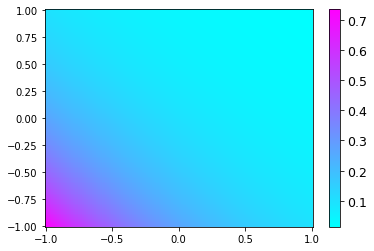

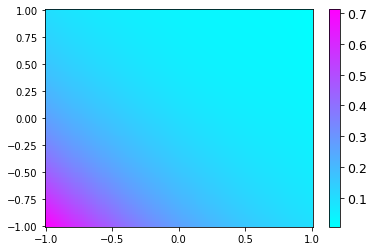

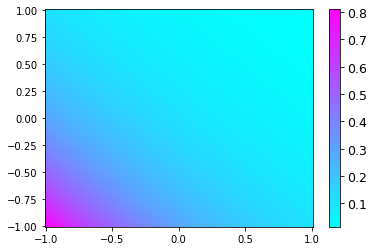

In [13]:
fig1 = plt.figure()
fig2 = plt.figure()
#ax1 = fig1.add_subplot(111, projection='3d')
#ax2 = fig2.add_subplot(111, projection='3d')
#print(x_t_test[:(N_xdata + 1)**2,0])
x = np.linspace(x_l, x_r, N_xdata + 1)  # x取值范围和精度
y = np.linspace(x_l, x_r, N_xdata + 1)  # y取值范围和精度
x1, y1 = np.meshgrid(x, y) 
#print(x)
#print(y)
z1 =  0.1 * np.exp(-x1)* np.exp(-y1) * np.cos(0.1)
#print(z1)
#z_1 = np.reshape(u_pred[:(N_xdata + 1)**2],[N_xdata + 1,N_xdata + 1])
#z_2 = np.reshape(u_pred[-4*(N_xdata + 1)**2:-3*(N_xdata + 1)**2],[N_xdata + 1,N_xdata + 1])
#z_3 = np.reshape(u_pred[-3*(N_xdata + 1)**2:-2*(N_xdata + 1)**2],[N_xdata + 1,N_xdata + 1])
#z_4 = np.reshape(u_pred[-2*(N_xdata + 1)**2:-(N_xdata + 1)**2],[N_xdata + 1,N_xdata + 1])
z_5 = np.reshape(u_pred[-(N_xdata + 1)**2:],[N_xdata + 1,N_xdata + 1])
z3 = np.reshape(0.1*np.exp(-x1)* np.exp(-y1) * np.cos(0),[N_xdata + 1,N_xdata + 1]) + 0.1 * z_5
#z2 =np.reshape(u_pred[:(N_xdata + 1)**2],[N_xdata + 1,N_xdata + 1])
plt.pcolor(x, y, z1, cmap='cool')
clb = plt.colorbar()
clb.ax.tick_params(labelsize=12.5)
plt.show()
plt.pcolor(x, y, z_5, cmap='cool')
plt.savefig("predicted_test.jpg")
clb = plt.colorbar()
clb.ax.tick_params(labelsize=12.5)
plt.show()

plt.pcolor(x, y, z3, cmap='cool')
clb = plt.colorbar()
clb.ax.tick_params(labelsize=12.5)
plt.show()

30 -60


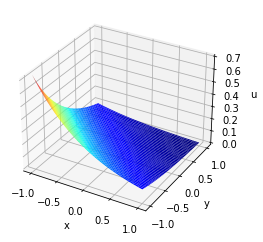

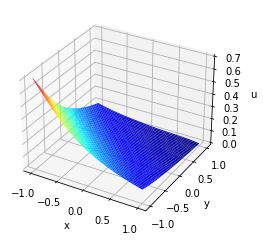

In [45]:
fig1 = plt.figure()
fig2 = plt.figure()
ax1 = fig1.add_subplot(111, projection='3d')
ax2 = fig2.add_subplot(111, projection='3d')
#print(x_t_test[:(N_xdata + 1)**2,0])
x = np.linspace(x_l, x_r, N_xdata + 1)  # x取值范围和精度
y = np.linspace(x_l, x_r, N_xdata + 1)  # y取值范围和精度
x1, y1 = np.meshgrid(x, y) 
#print(x)
#print(y)
z1 =  0.1*np.exp(-x1)* np.exp(-y1) * np.cos(0.1)
#print(z1)
z_5 = np.reshape(u_pred[-(N_xdata + 1)**2:],[N_xdata + 1,N_xdata + 1])

ax1.plot_surface(x1, y1, z1, cmap='jet')

ax1.set_xlabel("x")
ax1.set_ylabel("y")
ax1.set_zlabel("u")
ax1.set_zlim(0,0.7)
plt.savefig("real_ad.jpg")
#ax1.view_init(elev=40,azim=-50)
#clb = plt.colorbar()
#clb.ax.tick_params(labelsize=12.5)


ax2.plot_surface(x1, y1, z_5, cmap='jet')
print(ax2.elev,ax2.azim)
ax2.set_zlim(0,0.7)
ax2.set_xlabel("x")
ax2.set_ylabel("y")
ax2.set_zlabel("u")
plt.savefig("predicted_ad.jpg")
#clb = plt.colorbar()
#clb.ax.tick_params(labelsize=12.5)
plt.show()



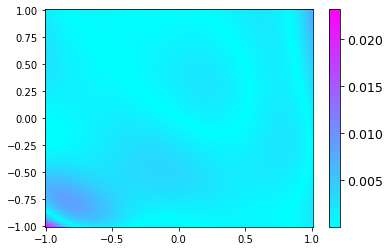

In [46]:
error = abs(z1-z_5)
#print(error)
plt.pcolor(x, y, error,cmap="cool")
clb = plt.colorbar()
clb.ax.tick_params(labelsize=12.5)
plt.savefig("error_ad.jpg")
plt.show()